In [139]:
import pandas as pd

#wizualizacja
import matplotlib.pyplot as plt
import seaborn as sns

#Obrobka danych
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
#balansowanie ilosciami probek dla klas
from imblearn.over_sampling import SMOTE

#Biblioteki dla modeli
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


#metryki
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import label_binarize

#Obróbka danych#

In [113]:
# 1. Załadowanie danych
file_path = "penguins.csv"  # Ścieżka do pliku
penguins_data = pd.read_csv(file_path)

# 2. Usunięcie brakujących danych
penguins_data_cleaned = penguins_data.dropna()

# 3. Wybór zmiennych numerycznych i targetu
numerical_columns = ['CulmenLength', 'CulmenDepth', 'FlipperLength', 'BodyMass']  # Zmienne numeryczne
target_column = 'Species'  # Target (klasa)

# Konwersja targetu do postaci numerycznej
penguins_data_cleaned['Species_numeric'] = penguins_data_cleaned['Species'].astype('category').cat.codes

# Podział na cechy (X) i target (y)
X = penguins_data_cleaned[numerical_columns]
y = penguins_data_cleaned['Species_numeric']

# 4. Podział na dane treningowe i testowe
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% trening, 30% test

# 5. Standaryzacja danych
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Tworzenie cech wielomianowych
poly = PolynomialFeatures(degree=2, include_bias=False)  # Stworzenie interakcji i kwadratów
X_train_poly = poly.fit_transform(X_train_scaled)  # Dopasowanie i transformacja danych treningowych
X_test_poly = poly.transform(X_test_scaled)        # Transformacja danych testowych
poly_features = poly.get_feature_names_out(numerical_columns)

# 7. Balansowanie danych za pomocą SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_poly, y_train)

print("Rozmiar danych treningowych po balansowaniu:")
print(f"X_train_balanced: {X_train_balanced.shape}, y_train_balanced: {len(y_train_balanced)}")
print("Rozkład klas po balansowaniu:")
print(pd.Series(y_train_balanced).value_counts())

# 8. Redukcja wymiaru za pomocą PCA
pca = PCA(n_components=4)  # Redukcja do 4 głównych składowych
X_train_pca = pca.fit_transform(X_train_balanced)  # Dopasowanie PCA do danych zbalansowanych
X_test_pca = pca.transform(X_test_poly)           # Zastosowanie PCA na danych testowych

# 9. Utworzenie DataFrame dla PCA
train_pca_df = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(4)])
test_pca_df = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(4)])

# Dodanie klas do danych PCA
train_pca_df['Species_numeric'] = y_train_balanced
test_pca_df['Species_numeric'] = y_test

# 10. Obliczenie korelacji głównych składowych z klasą Species_numeric
pca_train_correlations = train_pca_df.corr(numeric_only=True)['Species_numeric'].drop('Species_numeric')

# Wyświetlenie wyników
pca_variance_ratios = pca.explained_variance_ratio_  # Wskaźnik wyjaśnionej wariancji przez każdą składową
print("Wyjaśniona wariancja dla każdej składowej PCA:", pca_variance_ratios)
print("Korelacje głównych składowych z klasą Species_numeric (trening):", pca_train_correlations.sort_values(ascending=False))

Rozmiar danych treningowych po balansowaniu:
X_train_balanced: (303, 14), y_train_balanced: 303
Rozkład klas po balansowaniu:
Species_numeric
0    101
1    101
2    101
Name: count, dtype: int64
Wyjaśniona wariancja dla każdej składowej PCA: [0.36583695 0.19614089 0.14893575 0.09177978]
Korelacje głównych składowych z klasą Species_numeric (trening): PC3    0.570431
PC2    0.367671
PC1   -0.210009
PC4   -0.466102
Name: Species_numeric, dtype: float64


<ipython-input-113-23d3478689b8>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  penguins_data_cleaned['Species_numeric'] = penguins_data_cleaned['Species'].astype('category').cat.codes


In [116]:
pd.Series(y_train_balanced).value_counts()

,count
Species_numeric,
0,101
1,101
2,101


In [118]:
print("Rozmiar danych treningowych:")
print("X_train_pca:", X_train_pca.shape)
print("y_train_balanced:", len(y_train_balanced))

print("Rozmiar danych testowych:")
print("X_test_pca:", X_test_pca.shape)
print("y_test:", len(y_test))

Rozmiar danych treningowych:
X_train_pca: (303, 4)
y_train_balanced: 303
Rozmiar danych testowych:
X_test_pca: (103, 4)
y_test: 103


In [119]:
print("Rozmiar danych po SMOTE:")
print("X_train_balanced:", X_train_balanced.shape)
print("y_train_balanced:", len(y_train_balanced))

Rozmiar danych po SMOTE:
X_train_balanced: (303, 14)
y_train_balanced: 303


#Calculate_metrics#

In [121]:
metrics_dataframe = pd.DataFrame(columns=['Model', 'F1_score', 'AUC', 'F1_cross'])
models = []
models_names = []
predictions_proba_list = []

def calculate_metrics(model, name, X_checked, y_checked):
    models.append(model)
    models_names.append(name)
    global metrics_dataframe

    # Predykcje i prawdopodobieństwa
    predictions = model.predict(X_checked)
    predictions_proba = model.predict_proba(X_checked)
    predictions_proba_list.append(predictions_proba)

    # **Metryki dla modelu**
    # Classification Report (dla binarnego i wieloklasowego problemu)
    print(classification_report(y_checked, predictions))

    # Confusion Matrix
    plt.figure()
    cm = confusion_matrix(y_checked, predictions)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    plt.title('Confusion Matrix\n\n')
    plt.xlabel('\nPredicted Values')
    plt.ylabel('Actual Values')
    plt.show()

    # **Obsługa wieloklasowości**
    # Jeśli problem jest wieloklasowy, zbinaryzuj klasy
    classes = sorted(set(y_checked))
    is_multiclass = len(set(y_checked))

    if is_multiclass:
        y_checked_binarized = label_binarize(y_checked, classes=classes)

        # F1-score (średnia ważona dla wieloklasowości)
        f1_metric = f1_score(y_checked, predictions, average='weighted')

        # AUC (dla podejścia one-vs-rest)
        auc_metric = roc_auc_score(y_checked_binarized, predictions_proba, multi_class='ovr')
    else:
        # F1-score (dla problemu binarnego)
        f1_metric = f1_score(y_checked, predictions)

        # AUC (dla problemu binarnego)
        auc_metric = roc_auc_score(y_checked, predictions_proba[:, 1])

    #f1_scoer z walidacja krzyzowa
    f1_cross_val_scores = cross_val_score(model, X_checked, y_checked, cv=5, scoring='f1_macro')

    # Wykres ROC
    fig = plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    for model_selected, name_selected, pred_proba in zip(models, models_names, predictions_proba_list):
        # Dla każdej klasy rysuj oddzielną krzywą ROC
        for i, cls in enumerate(classes):
            fpr, tpr, thresholds = roc_curve(y_checked_binarized[:, i], pred_proba[:, i])
            plt.plot(fpr, tpr, label=f"{name_selected} (class {cls})")

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc=(1.05, 0.8))
    plt.show()

    # Dodanie wyników do globalnej tabeli
    metrics_dataframe = pd.concat([metrics_dataframe, pd.DataFrame([{
        'Model': name,
        'F1_score': f1_metric,
        'AUC': auc_metric,
        'F1_cross' : f1_cross_val_scores.mean()
    }])], ignore_index=True)

    return metrics_dataframe

#Modele#

##LogisticRegression##

In [122]:
model_lr = LogisticRegression(random_state = 42)

params_rf = {'penalty': ['l1', 'l2', 'elasticnet'],
             'solver': ['saga', 'lbfgs', 'liblinear'],
             'max_iter': [100, 1000, 10000],
             'C': [0.1, 1, 10],
             'l1_ratio': [0.1, 0.5, 0.7, 1.0]}

# Filtracja niepoprawnych kombinacji (dla elasticnet i l1)
valid_params = []
for penalty in ['l1', 'l2', 'elasticnet']:
    for solver in ['saga', 'lbfgs', 'liblinear']:
        if penalty == 'elasticnet' and solver != 'saga':
            continue
        if penalty == 'l1' and solver not in ['liblinear', 'saga']:
            continue
        if penalty == 'none' and solver not in ['saga', 'lbfgs']:
            continue

        if penalty == 'elasticnet':
            valid_params.append({'penalty': [penalty], 'solver': [solver], 'l1_ratio': [0.1, 0.5, 0.7, 1.0]})
        else:
            valid_params.append({'penalty': [penalty], 'solver': [solver]})

# Przekształć listę filtracji na grid parametrów
param_grid = [{**param, 'max_iter': [100, 1000, 10000], 'C': [0.1, 1, 10]} for param in valid_params]

rf_gridsearch = GridSearchCV(model_lr,
                             param_grid,
                             scoring='f1_macro',
                             cv=5,
                             verbose=10,
                             n_jobs=-1)
rf_gridsearch.fit(X_train_pca, y_train_balanced)
print('\nBest hyperparameter:', rf_gridsearch.best_params_)
rf_model_v2 = rf_gridsearch.best_estimator_

model_lr = rf_model_v2.fit(X_train_pca, y_train_balanced)

Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best hyperparameter: {'C': 1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


              precision    recall  f1-score   support

           0       0.98      0.98      0.98        50
           1       1.00      1.00      1.00        34
           2       0.95      0.95      0.95        19

    accuracy                           0.98       103
   macro avg       0.98      0.98      0.98       103
weighted avg       0.98      0.98      0.98       103



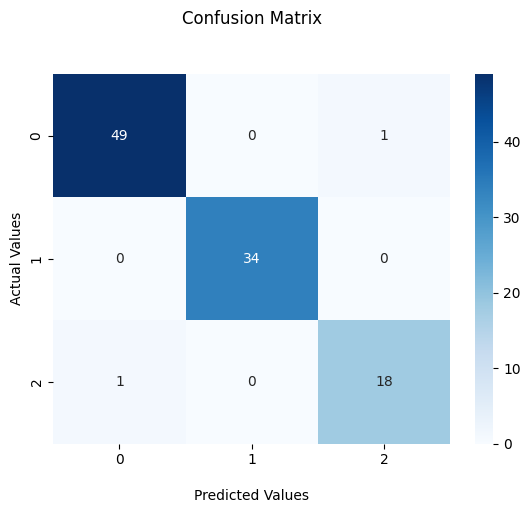

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


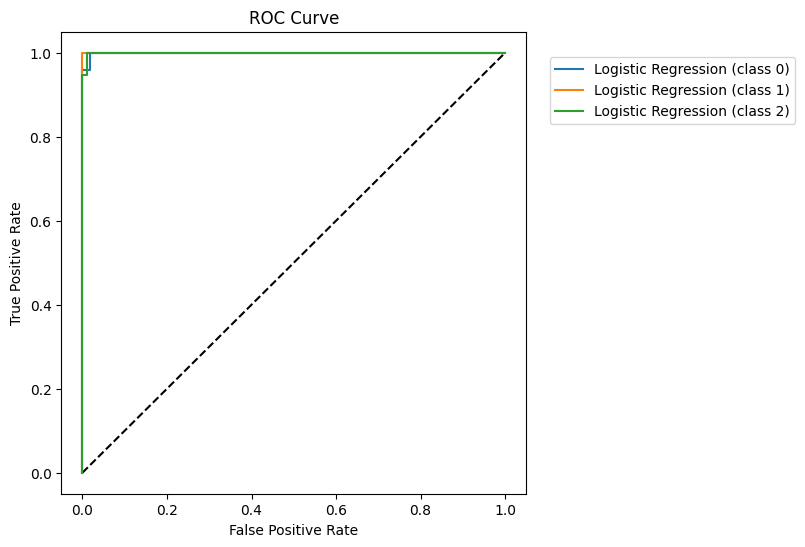

<ipython-input-121-f22dbfb0ba80>:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_dataframe = pd.concat([metrics_dataframe, pd.DataFrame([{


,Model,F1_score,AUC,F1_cross
0,Logistic Regression,0.980583,0.99954,0.958413


In [123]:
calculate_metrics(model_lr, 'Logistic Regression', X_test_pca, y_test)

##KNN##

In [124]:
model_knn = KNeighborsClassifier()

params_rf = {'n_neighbors': [3, 5, 10, 20, 100]}
rf_gridsearch = GridSearchCV(model_knn,
                             params_rf,
                             scoring='f1_macro',
                             cv=5,
                             verbose=10, n_jobs=-1)
rf_gridsearch.fit(X_train_pca, y_train_balanced)
print('\nBest hyperparameter:', rf_gridsearch.best_params_)
rf_model_v2 = rf_gridsearch.best_estimator_

model_knn = rf_model_v2.fit(X_train_pca, y_train_balanced)

Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best hyperparameter: {'n_neighbors': 3}


              precision    recall  f1-score   support

           0       1.00      0.96      0.98        50
           1       1.00      1.00      1.00        34
           2       0.90      1.00      0.95        19

    accuracy                           0.98       103
   macro avg       0.97      0.99      0.98       103
weighted avg       0.98      0.98      0.98       103



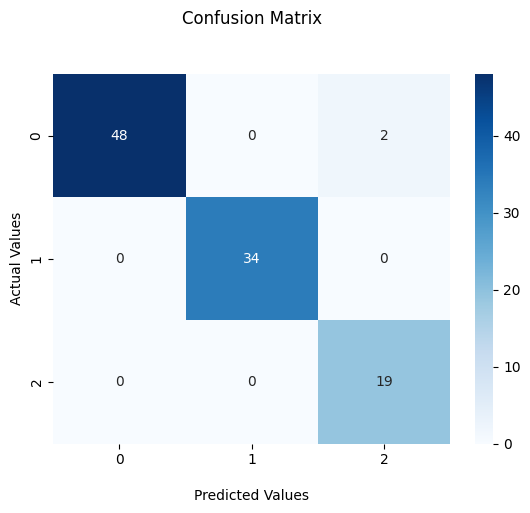

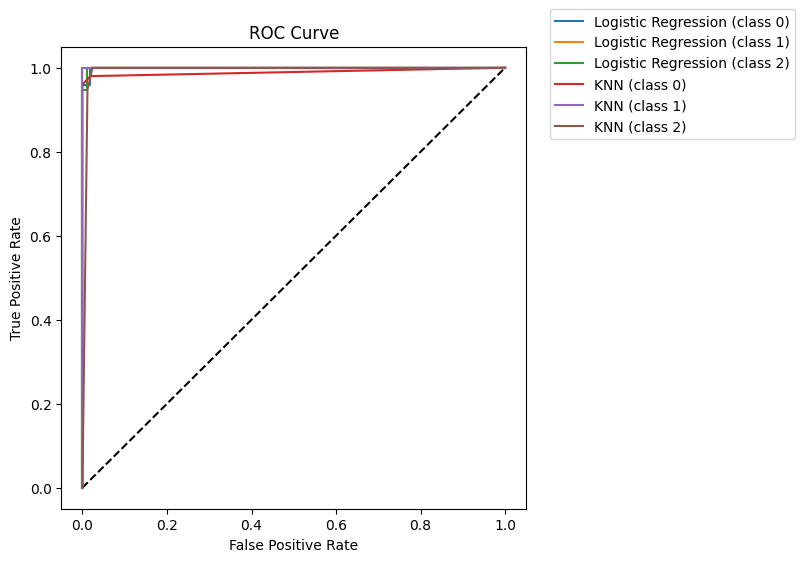

,Model,F1_score,AUC,F1_cross
0,Logistic Regression,0.980583,0.999540,0.958413
1,KNN,0.980870,0.994348,0.970794


In [125]:
calculate_metrics(model_knn, 'KNN', X_test_pca, y_test)

##Drzewo decyzyjne##

In [126]:
model_tree = DecisionTreeClassifier(random_state = 42)

params_rf = {'max_depth': [3, 5, 10, 20],
             'min_samples_leaf': [3, 5, 10, 15]}

rf_gridsearch = GridSearchCV(model_tree,
                             params_rf,
                             scoring='f1_macro',
                             cv=5,
                             verbose=10,
                             n_jobs=-1)

rf_gridsearch.fit(X_train_pca, y_train_balanced)
print('\nBest hyperparameter:', rf_gridsearch.best_params_)
rf_model_v2 = rf_gridsearch.best_estimator_

model_tree = rf_model_v2.fit(X_train_pca, y_train_balanced)

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best hyperparameter: {'max_depth': 5, 'min_samples_leaf': 3}


              precision    recall  f1-score   support

           0       1.00      0.82      0.90        50
           1       0.89      1.00      0.94        34
           2       0.79      1.00      0.88        19

    accuracy                           0.91       103
   macro avg       0.90      0.94      0.91       103
weighted avg       0.93      0.91      0.91       103



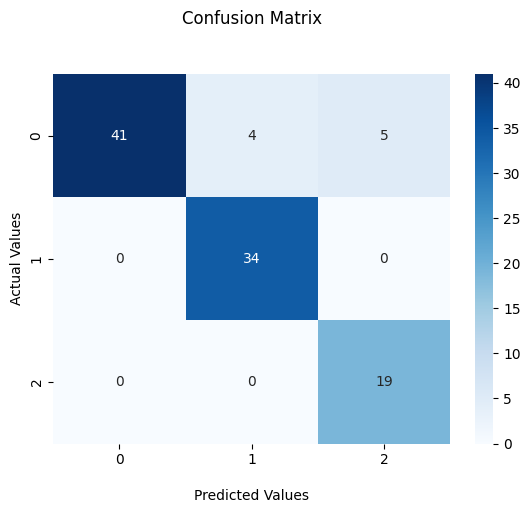

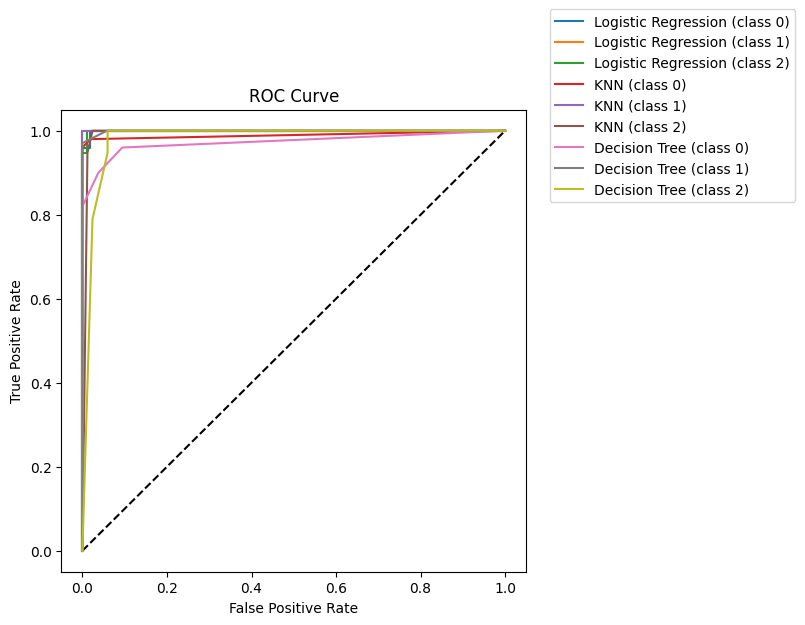

,Model,F1_score,AUC,F1_cross
0,Logistic Regression,0.980583,0.999540,0.958413
1,KNN,0.980870,0.994348,0.970794
2,Decision Tree,0.912201,0.984226,0.909493


In [127]:
calculate_metrics(model_tree, 'Decision Tree', X_test_pca, y_test)

##SVM - model parametryczny##

In [128]:
model_svm = SVC(probability = True)

params_rf = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

rf_gridsearch = GridSearchCV(model_svm,
                             params_rf,
                             scoring='f1_macro',
                             cv=5,
                             verbose=10,
                             n_jobs=-1)

rf_gridsearch.fit(X_train_pca, y_train_balanced)
print('\nBest hyperparameter:', rf_gridsearch.best_params_)
rf_model_v2 = rf_gridsearch.best_estimator_

model_svm = rf_model_v2.fit(X_train_pca, y_train_balanced)

Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best hyperparameter: {'kernel': 'rbf'}


              precision    recall  f1-score   support

           0       0.98      0.98      0.98        50
           1       1.00      1.00      1.00        34
           2       0.95      0.95      0.95        19

    accuracy                           0.98       103
   macro avg       0.98      0.98      0.98       103
weighted avg       0.98      0.98      0.98       103



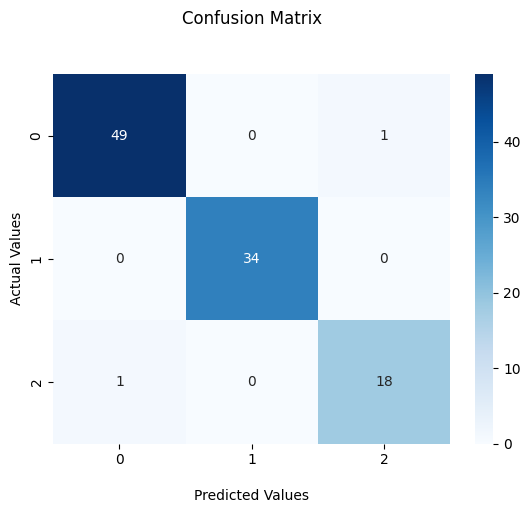

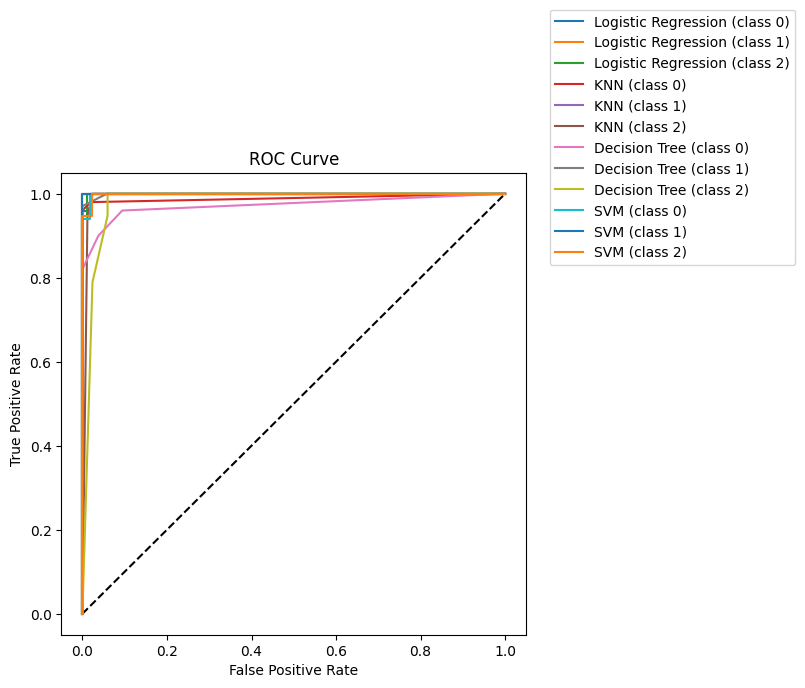

,Model,F1_score,AUC,F1_cross
0,Logistic Regression,0.980583,0.999540,0.958413
1,KNN,0.980870,0.994348,0.970794
2,Decision Tree,0.912201,0.984226,0.909493
3,SVM,0.980583,0.999205,0.958095


In [129]:
calculate_metrics(model_svm, 'SVM', X_test_pca, y_test)

##Random Forest##

In [131]:
model_forest = RandomForestClassifier(class_weight='balanced')

params_rf = {'n_estimators' : [100, 500, 1000],
             'max_depth' : [1, 3, 5, 8],
             'min_samples_leaf' : [1, 3, 5, 10, 20, 25]}

rf_gridsearch = GridSearchCV(model_forest,
                             params_rf,
                             scoring='f1_macro',
                             cv=5,
                             verbose=10,
                             n_jobs=-1)

rf_gridsearch.fit(X_train_pca, y_train_balanced)
print('\nBest hyperparameter:', rf_gridsearch.best_params_)
rf_model_v2 = rf_gridsearch.best_estimator_

model_forest = rf_model_v2.fit(X_train_pca, y_train_balanced)

Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best hyperparameter: {'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 100}


              precision    recall  f1-score   support

           0       1.00      0.84      0.91        50
           1       1.00      1.00      1.00        34
           2       0.70      1.00      0.83        19

    accuracy                           0.92       103
   macro avg       0.90      0.95      0.91       103
weighted avg       0.95      0.92      0.93       103



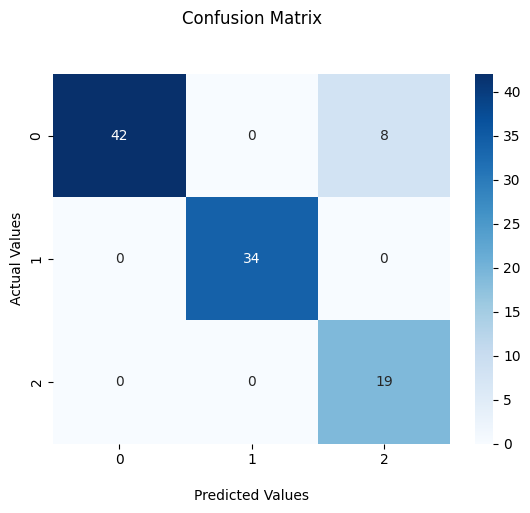

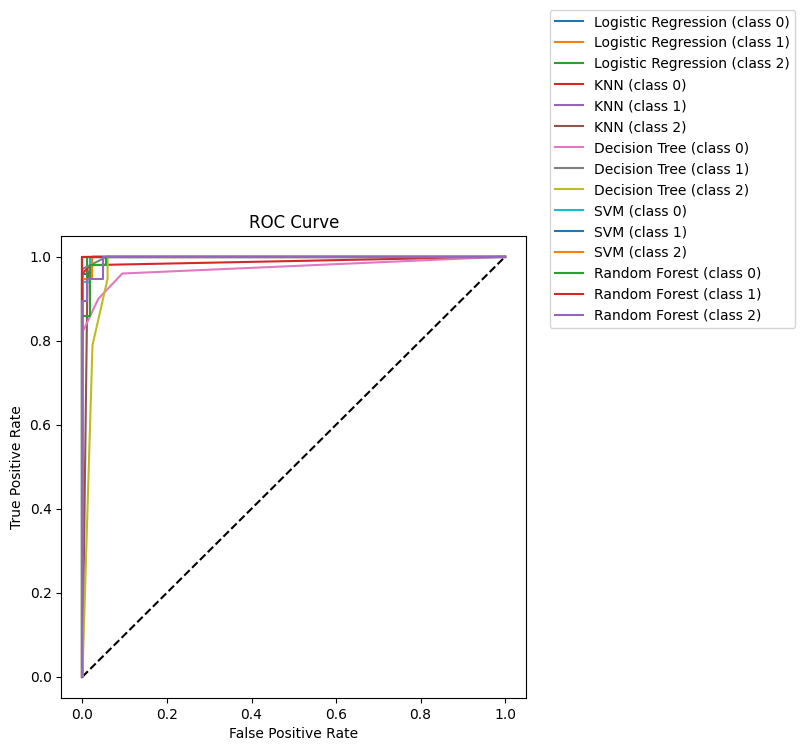

,Model,F1_score,AUC,F1_cross
0,Logistic Regression,0.980583,0.999540,0.958413
1,KNN,0.980870,0.994348,0.970794
2,Decision Tree,0.912201,0.984226,0.909493
3,SVM,0.980583,0.999205,0.958095
4,Random Forest,0.925707,0.997824,0.958413


In [132]:
calculate_metrics(model_forest, 'Random Forest', X_test_pca, y_test)

##Boosting - AdaBoost##

In [136]:
model_adaboost = AdaBoostClassifier()

params_rf = {'estimator' : [DecisionTreeClassifier()],
             'n_estimators' : [10, 20, 40, 60, 100]}

rf_gridsearch = GridSearchCV(model_adaboost,
                             params_rf,
                             scoring='f1_macro',
                             cv=5,
                             verbose=10,
                             n_jobs=-1)

rf_gridsearch.fit(X_train_pca, y_train_balanced)
print('\nBest hyperparameter:', rf_gridsearch.best_params_)
rf_model_v2 = rf_gridsearch.best_estimator_

model_adaboost = rf_model_v2.fit(X_train_pca, y_train_balanced)

Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best hyperparameter: {'estimator': DecisionTreeClassifier(), 'n_estimators': 40}


              precision    recall  f1-score   support

           0       0.98      0.94      0.96        50
           1       1.00      0.97      0.99        34
           2       0.86      1.00      0.93        19

    accuracy                           0.96       103
   macro avg       0.95      0.97      0.96       103
weighted avg       0.96      0.96      0.96       103



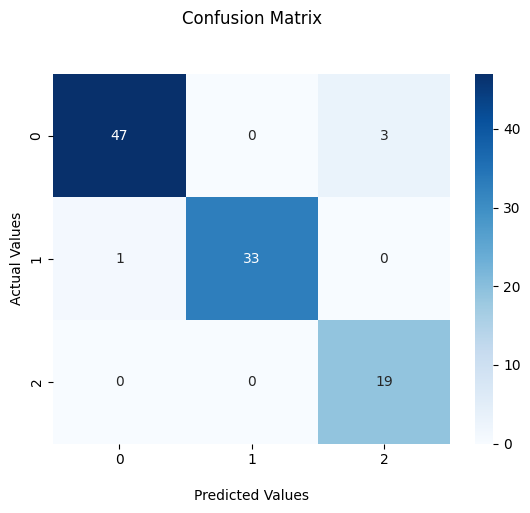

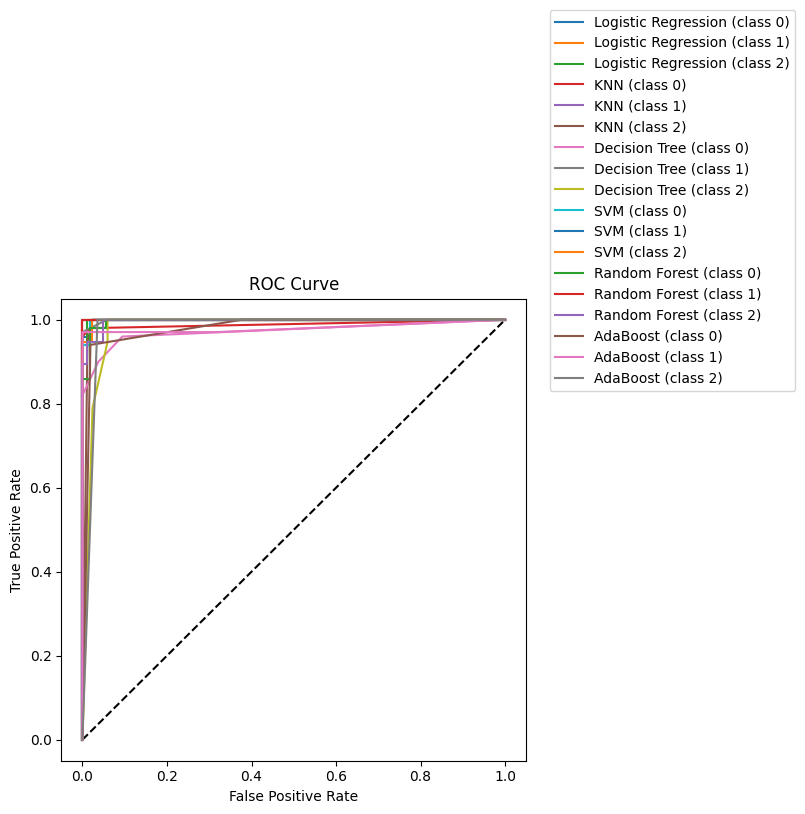

,Model,F1_score,AUC,F1_cross
0,Logistic Regression,0.980583,0.999540,0.958413
1,KNN,0.980870,0.994348,0.970794
2,Decision Tree,0.912201,0.984226,0.909493
3,SVM,0.980583,0.999205,0.958095
4,Random Forest,0.925707,0.997824,0.958413
5,AdaBoost,0.961762,0.980664,0.918243


In [137]:
calculate_metrics(model_adaboost, 'AdaBoost', X_test_pca, y_test)

##Ensembling - Zespół klasyfikatorów##

In [140]:
model_voting = VotingClassifier(estimators = [('Tree', DecisionTreeClassifier()),
                                               ('Random Forest', RandomForestClassifier()),
                                               ('AdaBoost', AdaBoostClassifier())],
                                voting = 'soft')

model_voting.fit(X_train_pca, y_train_balanced)

VotingClassifier(estimators=[('Tree', DecisionTreeClassifier()),
                             ('Random Forest', RandomForestClassifier()),
                             ('AdaBoost', AdaBoostClassifier())],
                 voting='soft')

              precision    recall  f1-score   support

           0       0.98      0.90      0.94        50
           1       0.94      0.97      0.96        34
           2       0.86      1.00      0.93        19

    accuracy                           0.94       103
   macro avg       0.93      0.96      0.94       103
weighted avg       0.95      0.94      0.94       103



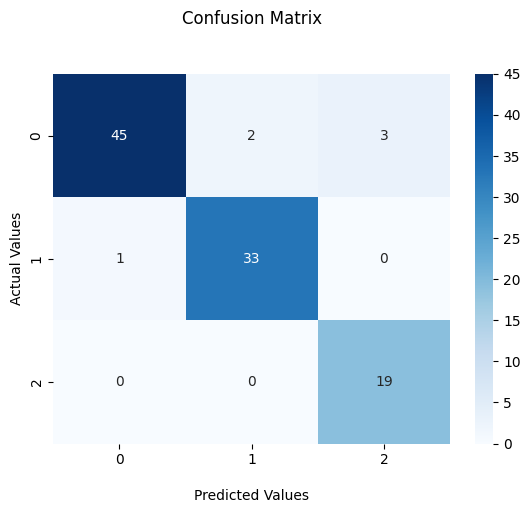

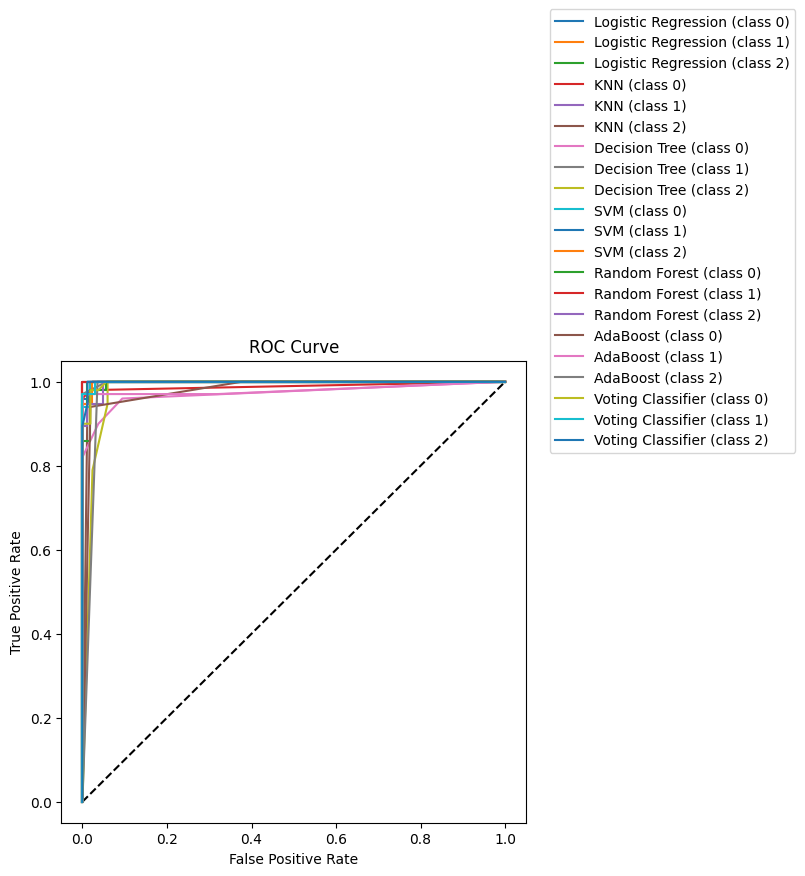

,Model,F1_score,AUC,F1_cross
0,Logistic Regression,0.980583,0.999540,0.958413
1,KNN,0.980870,0.994348,0.970794
2,Decision Tree,0.912201,0.984226,0.909493
3,SVM,0.980583,0.999205,0.958095
4,Random Forest,0.925707,0.997824,0.958413
5,AdaBoost,0.961762,0.980664,0.918243
6,Voting Classifier,0.941811,0.998585,0.918243


In [141]:
calculate_metrics(model_voting, 'Voting Classifier', X_test_pca, y_test)